In [475]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [476]:
bnb = pd.read_csv('AB_NYC_2019.csv')

In [477]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [478]:
bnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [479]:
# fill missing values in the name, host_name and last_review with 'unknown'
bnb['name'] = bnb['name'].fillna('unknown')
bnb['host_name'] = bnb['host_name'].fillna('unknown')
bnb['last_review'] = bnb['last_review'].fillna('unknown')
bnb[['name', 'host_name', 'last_review']].isnull().sum()

name           0
host_name      0
last_review    0
dtype: int64

In [480]:
# fill missing values in the 'reviews_per_month' using knn imputer
bnb_reviews = bnb[['reviews_per_month']]

# apply k-Nearest Neighbor imputer to handle missing values
imputer = KNNImputer(n_neighbors=3)
data_imputed = pd.DataFrame(imputer.fit_transform(bnb_reviews), columns=['reviews_per_month'])

# replace the original numeric columns with imputed values
bnb['reviews_per_month'] = data_imputed
bnb['reviews_per_month'].isnull().sum()

np.int64(0)

In [481]:
# check for duplicates
bnb.duplicated().sum()

np.int64(0)

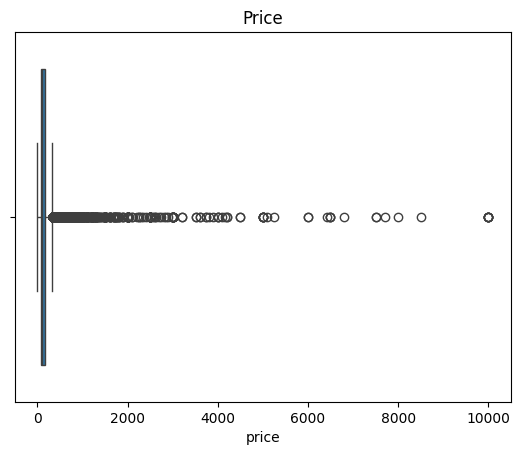

In [482]:
# price boxplot
sns.boxplot(x=bnb['price'], data=bnb)
plt.title('Price')
plt.show()

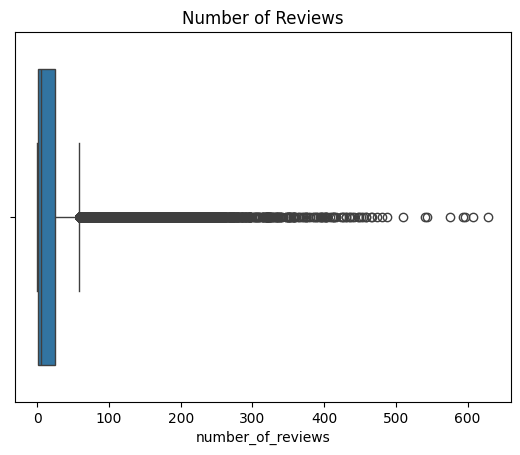

In [483]:
# no. of reviews boxplot
sns.boxplot(x=bnb['number_of_reviews'], data=bnb)
plt.title('Number of Reviews')
plt.show()

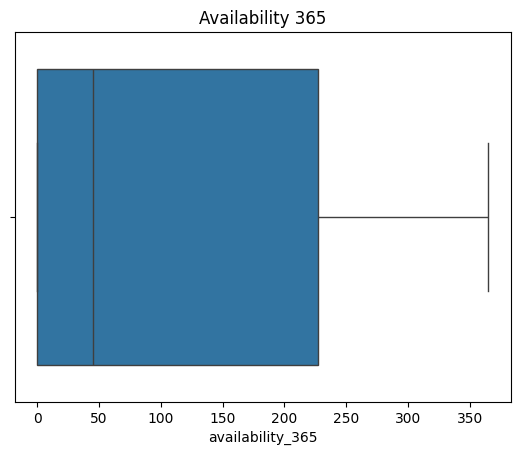

In [484]:
# availability boxplot
sns.boxplot(x=bnb['availability_365'], data=bnb)
plt.title('Availability 365')
plt.show()

In [485]:
# check outliers using IQR
# define a function to detect outliers using IQR 
def outliers(data, column):
    Q1 = data[column].quantile(0.25)  # first quartile 
    Q3 = data[column].quantile(0.75)  # third quartile 
    IQR = Q3 - Q1  # interquartile range
    lower = Q1 - 1.5 * IQR  # lower limit outliers
    upper = Q3 + 1.5 * IQR  # upper limit outliers

    # detect outliers
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers, lower, upper  # return outliers + lower + upper

# apply the function 
price_outliers, lower_price, upper_price = outliers(bnb, 'price')
reviews_outliers, lower_reviews, upper_reviews = outliers(bnb, 'number_of_reviews')
avail_outliers, lower_avail, upper_avail = outliers(bnb, 'availability_365')

# print outlier results
print(f"Number of 'price' outliers is: {len(price_outliers)}")
print(f"Percentage of 'price' outliers is: {len(price_outliers)/bnb.shape[0]*100:.02f}")

print(f"\nNumber of 'reviews' outliers is: {len(reviews_outliers)}")
print(f"Percentage of 'reviews' outliers is: {len(reviews_outliers)/bnb.shape[0]*100:.02f}")

print(f"\nNumber of 'availability' outliers is: {len(avail_outliers)}")
print(f"Percentage of 'availability' outliers is: {len(avail_outliers)/bnb.shape[0]*100:.02f}\n")

Number of 'price' outliers is: 2972
Percentage of 'price' outliers is: 6.08

Number of 'reviews' outliers is: 6021
Percentage of 'reviews' outliers is: 12.31

Number of 'availability' outliers is: 0
Percentage of 'availability' outliers is: 0.00



In [486]:
# remove detected outliers
# define function to remove outliers
def remove_outliers(bnb, col, lower, upper):
    bnb = bnb[(bnb[col] >= lower) & (bnb[col] <= upper)]
    
    # check for remaining outliers 
    recheck_outliers = ((bnb[col] < lower) | (bnb[col] > upper)).sum()
    print(f'Number of remaining {col} outliers: {recheck_outliers}')
    
    return bnb

# call and apply the function 
bnb = remove_outliers(bnb, 'price', lower_price, upper_price)
bnb = remove_outliers(bnb, 'number_of_reviews', lower_reviews, upper_reviews)
bnb = remove_outliers(bnb, 'availability_365', lower_avail, upper_avail)


Number of remaining price outliers: 0
Number of remaining number_of_reviews outliers: 0
Number of remaining availability_365 outliers: 0


In [487]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,unknown,1.373221,1,365
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.400000,1,0


In [488]:
bnb.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.007100e+04,4.007100e+04,40071.000000,40071.000000,40071.000000,40071.000000,40071.000000,40071.000000,40071.000000,40071.000000
mean,2.007926e+07,6.989555e+07,40.728757,-73.951475,120.375484,7.473784,9.822216,1.110333,7.305707,101.010556
std,1.078426e+07,8.006324e+07,0.055163,0.045763,68.820753,20.962132,13.435600,1.220884,33.133323,129.881450
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.040778e+07,8.594566e+06,40.690230,-73.982125,65.000000,1.000000,1.000000,0.220000,1.000000,0.000000
50%,2.110840e+07,3.245159e+07,40.722170,-73.954890,100.000000,3.000000,4.000000,0.900000,1.000000,21.000000
75%,2.996369e+07,1.124349e+08,40.763340,-73.935355,160.000000,5.000000,13.000000,1.373221,2.000000,188.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,334.000000,1250.000000,58.000000,20.940000,327.000000,365.000000


In [489]:
bnb.describe(include=object)

,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review
count,40071,40071,40071,40071,40071,40071
unique,39243,9974,5,217,3,1750
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt,unknown
freq,18,330,17270,3321,19837,9012


In [490]:
# check the room types and neighbourhood groups in the dataset
print(f'Room types are {bnb['room_type'].unique()}')
print(f'Neighbourhood groups are {bnb['neighbourhood_group'].unique()}')

Room types are ['Private room' 'Entire home/apt' 'Shared room']
Neighbourhood groups are ['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island']


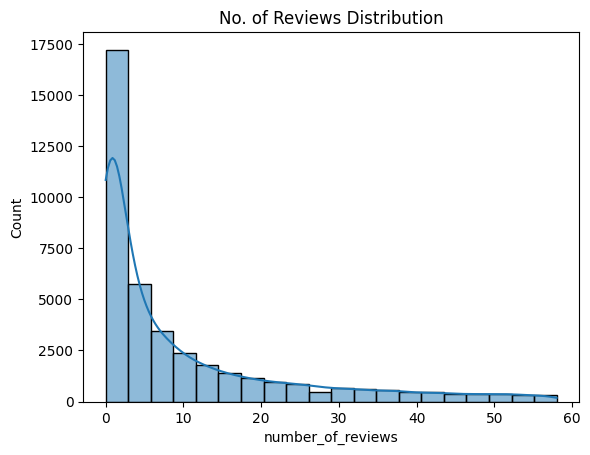

In [491]:
# no. of reviews distribution
sns.histplot(bnb['number_of_reviews'], kde=True, bins=20)
plt.title('No. of Reviews Distribution')
plt.show()

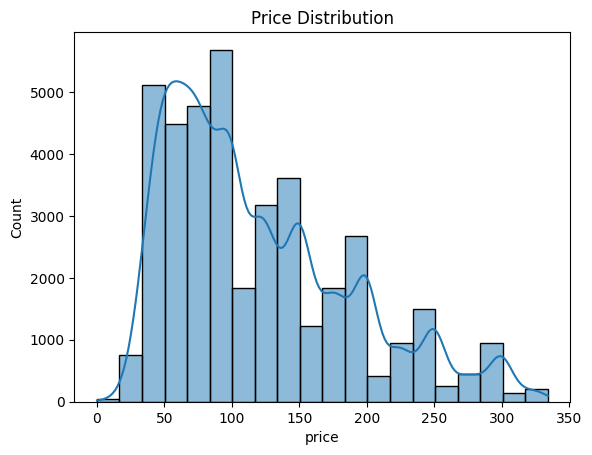

In [492]:
# price distribution
sns.histplot(bnb['price'], kde=True, bins=20)
plt.title('Price Distribution')
plt.show()

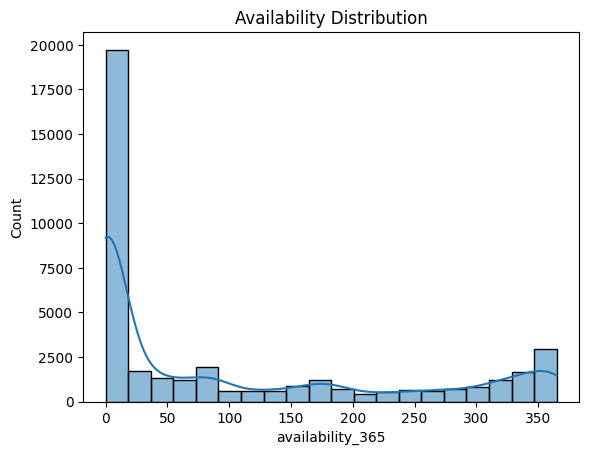

In [493]:
# availability distribution
sns.histplot(bnb['availability_365'], kde=True, bins=20)
plt.title('Availability Distribution')
plt.show()

                      price  number_of_reviews  availability_365
price              1.000000           -0.03440          0.067527
number_of_reviews -0.034400            1.00000          0.125460
availability_365   0.067527            0.12546          1.000000


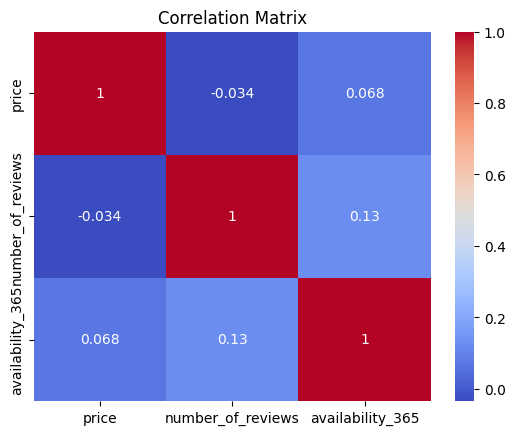

In [494]:
# correlation matrix 
numeric_sales = bnb[['price', 'number_of_reviews', 'availability_365']]
correlation_matrix = numeric_sales.corr() 
print(correlation_matrix)

# heatmap correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') 
plt.title('Correlation Matrix')
plt.show()

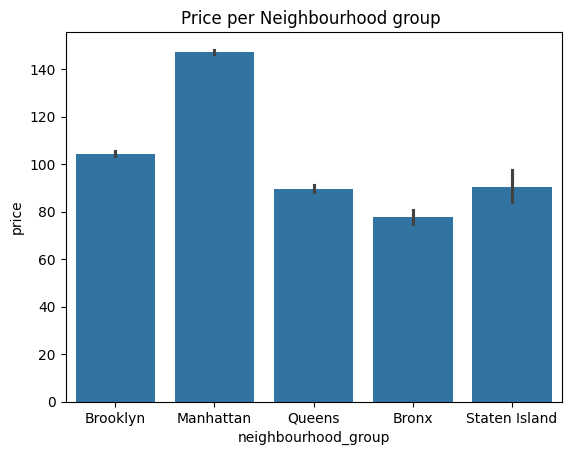

In [495]:
# price per neighbourhood group 
sns.barplot(x = 'neighbourhood_group', y = 'price', data=bnb )
plt.title('Price per Neighbourhood group ')
plt.show()

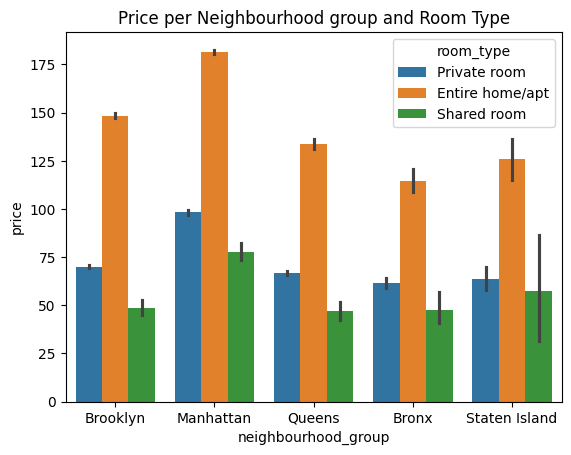

In [496]:
# price per neighbourhood group and room type
sns.barplot(x='neighbourhood_group', y='price', hue='room_type', data=bnb)
plt.title('Price per Neighbourhood group and Room Type')
plt.show()

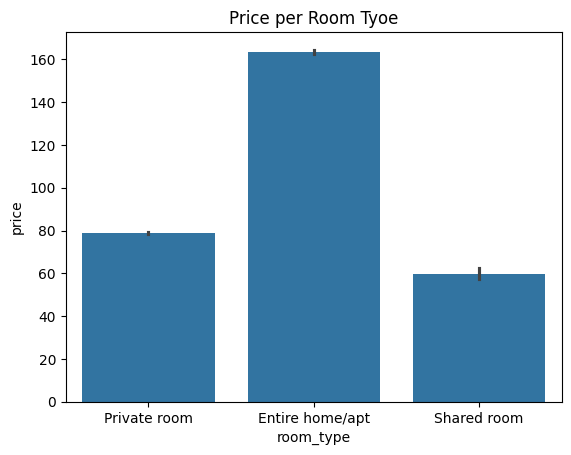

In [497]:
# price per room type
sns.barplot(x = 'room_type', y = 'price', data=bnb)
plt.title('Price per Room Tyoe')
plt.show()

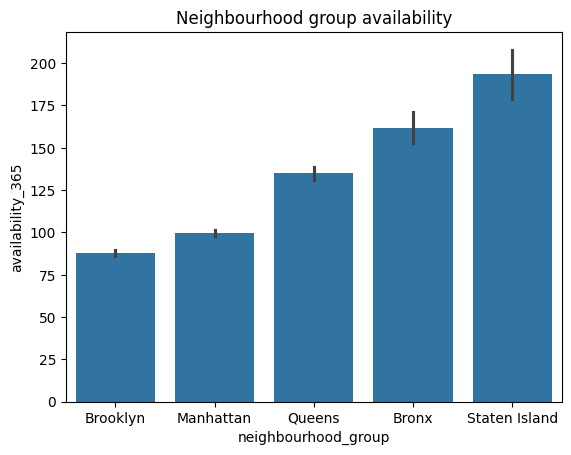

In [498]:
# neighbourhood group availability
sns.barplot(x='neighbourhood_group', y="availability_365", data=bnb)
plt.title('Neighbourhood group availability')
plt.show()

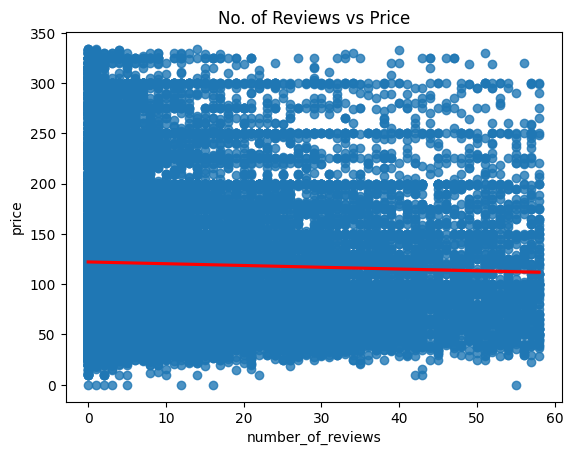

In [499]:
# regplot no. of reviews vs prive
sns.regplot(x='number_of_reviews', y='price', data=bnb, line_kws={'color': 'red'})
plt.title('No. of Reviews vs Price')
plt.show()

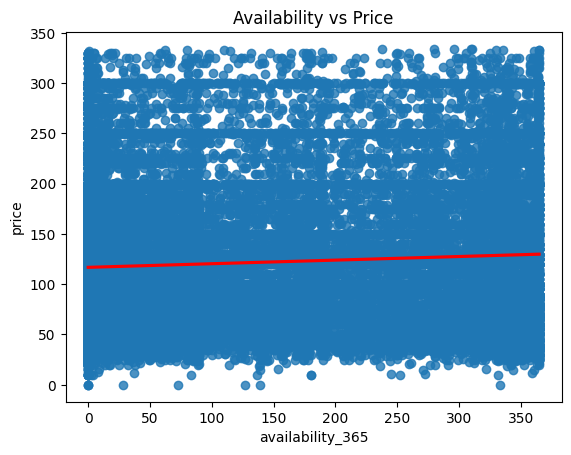

In [500]:
# regplot availability vs price
sns.regplot(x='availability_365', y='price', data=bnb, line_kws={'color': 'red'})
plt.title('Availability vs Price')
plt.show()

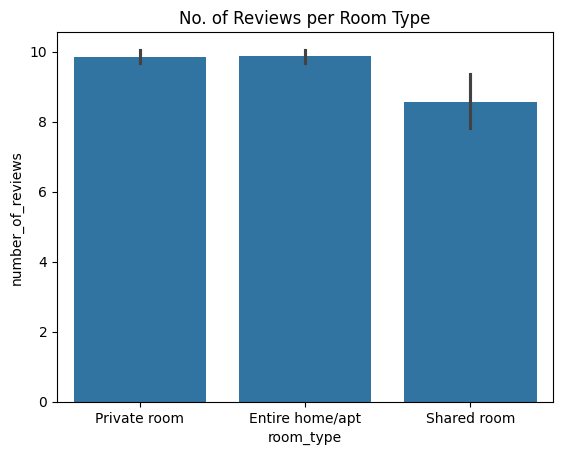

In [501]:
# no. of reviews per room type
sns.barplot(x='room_type', y="number_of_reviews", data=bnb)
plt.title('No. of Reviews per Room Type')
plt.show()

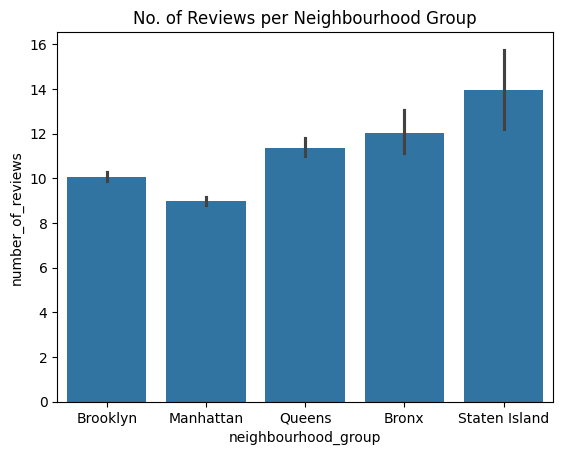

In [502]:
# no. of reviews per neighbourhood group
sns.barplot(x='neighbourhood_group', y="number_of_reviews", data=bnb)
plt.title('No. of Reviews per Neighbourhood Group')
plt.show()

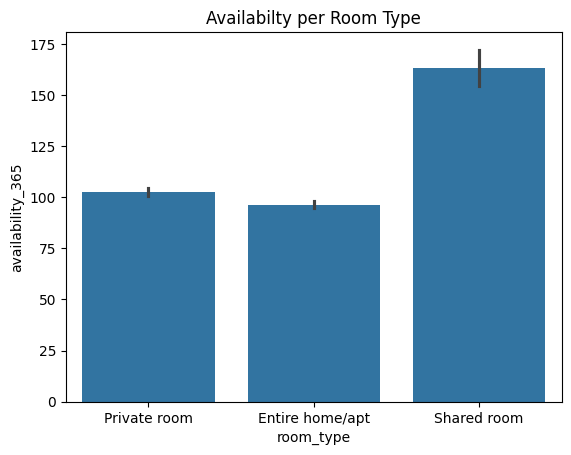

In [503]:
# availabilty per room type
sns.barplot(x='room_type', y="availability_365", data=bnb)
plt.title('Availabilty per Room Type')
plt.show()

In [504]:
# feature engineering
# transforming categorical variables room_type and neighbourhood_group into numerical values that a machine learning model can understand
bnb = pd.get_dummies(bnb, columns=['room_type','neighbourhood_group'])

In [505]:
bnb.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island'],
      dtype='object')

In [506]:
# price prediction model
# assign the features and target variables
X = bnb[['minimum_nights', 'reviews_per_month', 'calculated_host_listings_count',  'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens','neighbourhood_group_Staten Island', 'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room']]
y = bnb['price']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####################################
# define and fit the model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# model predition
lin_pred = lin_reg.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, lin_pred)
mae = mean_absolute_error(y_test, lin_pred)
r2 = r2_score(y_test, lin_pred)

# print the results
print('Linear Regression metrics:\n')
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

#####################################
# decision tree regressor
# define and fit the model
reg_tree = DecisionTreeRegressor(max_depth=5)
reg_tree.fit(X, y)

# model predition
reg_pred = reg_tree.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, reg_pred)
mae = mean_absolute_error(y_test, reg_pred)
r2 = r2_score(y_test, reg_pred)

# print the results
print('\nDecision Tree Regressor metrics:\n')
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Linear Regression metrics:

Mean Squared Error (MSE): 2547.83
Mean Absolute Error (MAE): 2547.83
R² Score: 0.46

Decision Tree Regressor metrics:

Mean Squared Error (MSE): 2438.30
Mean Absolute Error (MAE): 2438.30
R² Score: 0.48
